In [29]:
!nvcc --version
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc_plugin

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-4slp4xv4
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-4slp4xv4
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit 0a71d56e5dce3ff1f0dd2c47c29367629262f527
  Preparing metadata (setup.py) ... done
The nvcc_plugin extension is already loaded. To reload it, use:
  %reload_ext nvcc_plugin


In [30]:
!/usr/local/cuda/bin/nvcc --version
#!pip install --upgrade git+https://github.com/frehseg/nvcc4jupyter.git
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc_plugin
!cuda-install-samples-11.2.sh ~ && cd /root/NVIDIA_CUDA-11.2_Samples/

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-adzts4s7
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-adzts4s7
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit 0a71d56e5dce3ff1f0dd2c47c29367629262f527
  Preparing metadata (setup.py) ... done
The nvcc_plugin extension is already loaded. To reload it, use:
  %reload_ext nvcc_plugin
/bin/bash: line 1: cuda-install-samples-11.2.sh: command not found


In [31]:
!apt-get -y install libopencv-dev
!apt-get -y install libopencv-core-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libopencv-dev is already the newest version (4.5.4+dfsg-9ubuntu4).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libopencv-core-dev is already the newest version (4.5.4+dfsg-9ubuntu4).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


In [32]:
%%cuda --name my_curand.cu

#include <iostream>
#include <chrono>
#include <cuda_runtime.h>
#include <cuda_texture_types.h>
#include <opencv2/opencv.hpp>

#define CUDA_CHECK_ERROR() do { \
    cudaError_t err = cudaGetLastError(); \
    if (err != cudaSuccess) { \
        std::cerr << "CUDA error: " << cudaGetErrorString(err) << " at " << __FILE__ << ":" << __LINE__ << std::endl; \
        exit(-1); \
    } \
} while (0)

__device__ float gauss_GPU(float x) {
    return 0.2f * expf(-(x * x) / 10.0f);
}

__host__ float gauss_CPU(float x) {
    return 0.2f * exp(-(x * x) / 10.0);
}

__global__ void GPU_bilateral_filter(const uchar* input_image, uchar* res, int height, int width) {
    int i = blockIdx.y * blockDim.y + threadIdx.y;
    int j = blockIdx.x * blockDim.x + threadIdx.x;

    if (i < height && j < width) {
        float current_pixel = static_cast<float>(input_image[i * width + j]) / 255.0f;
        int min_i = max(0, i - 4);
        int max_i = min(height - 1, i + 4);
        int min_j = max(0, j - 4);
        int max_j = min(width - 1, j + 4);
        float k = 0.0f;
        float value = 0.0f;

        for (int x = min_i; x <= max_i; ++x) {
            for (int y = min_j; y <= max_j; ++y) {
                float f = static_cast<float>(input_image[x * width + y]) / 255.0f;
                float r = gauss_GPU(f - current_pixel);
                float dist_x = static_cast<float>((x - i) * (x - i));
                float dist_y = static_cast<float>((y - j) * (y - j));
                float g = gauss_GPU(dist_x + dist_y);
                value += f * r * g;
                k += g * r;
            }
        }

        res[i * width + j] = static_cast<uchar>(255.0f * value / k);
    }
}

cv::Mat CPU_bilateral_filter(const cv::Mat& input_image, int kernel) {
    int height = input_image.rows;
    int width = input_image.cols;
    cv::Mat res(height, width, CV_8UC1);

    for (int i = 0; i < height; ++i) {
        for (int j = 0; j < width; ++j) {
            float current_pixel = static_cast<float>(input_image.at<uchar>(i, j)) / 255.0f;
            int min_i = std::max(0, i - kernel);
            int max_i = std::min(height - 1, i + kernel);
            int min_j = std::max(0, j - kernel);
            int max_j = std::min(width - 1, j + kernel);
            float k = 0.0f;
            float value = 0.0f;

            for (int x = min_i; x <= max_i; ++x) {
                for (int y = min_j; y <= max_j; ++y) {
                    float f = static_cast<float>(input_image.at<uchar>(x, y)) / 255.0f;
                    float r = gauss_CPU(f - current_pixel);
                    float dist_x = static_cast<float>((x - i) * (x - i));
                    float dist_y = static_cast<float>((y - j) * (y - j));
                    float g = gauss_CPU(dist_x + dist_y);
                    value += f * r * g;
                    k += g * r;
                }
            }

            res.at<uchar>(i, j) = static_cast<uchar>(255.0f * value / k);
        }
    }

    return res;
}

int main() {
    cv::Mat inputImage = cv::imread("2000x2000.bmp", cv::IMREAD_GRAYSCALE);
    if (inputImage.empty()) {
        std::cerr << "Error: Could not read input image." << std::endl;
        return -1;
    }

    int threads_per_block_x = 32;
    int threads_per_block_y = 32;
    int blocks_per_grid_x = (inputImage.cols + threads_per_block_x - 1) / threads_per_block_x;
    int blocks_per_grid_y = (inputImage.rows + threads_per_block_y - 1) / threads_per_block_y;

    dim3 threads_per_block(threads_per_block_x, threads_per_block_y);
    dim3 blocks_per_grid(blocks_per_grid_x, blocks_per_grid_y);

    int kernel = 4;

    int w = inputImage.cols;
    int h = inputImage.rows;

    auto start_CPU = std::chrono::high_resolution_clock::now();
    cv::Mat result_CPU = CPU_bilateral_filter(inputImage, kernel);
    auto end_CPU = std::chrono::high_resolution_clock::now();
    std::chrono::duration<double> execution_CPU = end_CPU - start_CPU;
    std::cout << "Dimension: (" << w << ", " << h << ") CPU Execution Time: " << execution_CPU.count() << " seconds\n";

    cv::imwrite("CPU_" + std::to_string(w) + "x" + std::to_string(h) + ".bmp", result_CPU);

    uchar* d_input, *d_output;
    cudaMalloc((void**)&d_input, inputImage.total() * sizeof(uchar));
    cudaMalloc((void**)&d_output, inputImage.total() * sizeof(uchar));
    cudaMemcpy(d_input, inputImage.data, inputImage.total() * sizeof(uchar), cudaMemcpyHostToDevice);

    auto start_GPU = std::chrono::high_resolution_clock::now();
    GPU_bilateral_filter<<<blocks_per_grid, threads_per_block>>>(d_input, d_output, inputImage.rows, inputImage.cols);
    cudaDeviceSynchronize();
    auto end_GPU = std::chrono::high_resolution_clock::now();
    std::chrono::duration<double> execution_GPU = end_GPU - start_GPU;
    std::cout << "Dimension: (" << w << ", " << h << ") GPU Execution Time: " << execution_GPU.count() << " seconds\n";

    cv::Mat result_GPU(inputImage.rows, inputImage.cols, CV_8UC1);
    cudaMemcpy(result_GPU.data, d_output, result_GPU.total() * sizeof(uchar), cudaMemcpyDeviceToHost);
    cv::imwrite("GPU_" + std::to_string(w) + "x" + std::to_string(h) + ".bmp", result_GPU);

    std::cout << "Equality check: " << (cv::countNonZero(result_GPU == result_CPU) == result_GPU.total()) << "\n";

    cudaFree(d_input);
    cudaFree(d_output);

    return 0;
}

'File written in /content/src/my_curand.cu'

In [33]:
!apt-get -y install libopencv-dev
!apt-get -y install libopencv-core-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libopencv-dev is already the newest version (4.5.4+dfsg-9ubuntu4).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libopencv-core-dev is already the newest version (4.5.4+dfsg-9ubuntu4).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


In [34]:
!nvcc -o /content/src/my_curand /content/src/my_curand.cu -lcurand -lcublas -I/usr/include/opencv4 -I/usr/include -L/usr/lib -lopencv_core -lopencv_highgui -lopencv_imgproc -lopencv_imgcodecs

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::buildMaps" is only partially overridden in class "cv::detail::AffineWarper"
  class AffineWarper : public PlaneWarper
        ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::warp" is only partially overridden in class "cv::detail::AffineWarper"
  class AffineWarper : public PlaneWarper
        ^

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(100): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is only partially overridden in class "cv::detail::FeatherBlender"
  class FeatherBlender : public Blender
        ^

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(127): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is

In [35]:
!/content/src/my_curand

Dimension: (2000, 2000) CPU Execution Time: 16.2571 seconds
Dimension: (2000, 2000) GPU Execution Time: 0.0142648 seconds
Equality check: 0


In [36]:
!pip install matplotlib

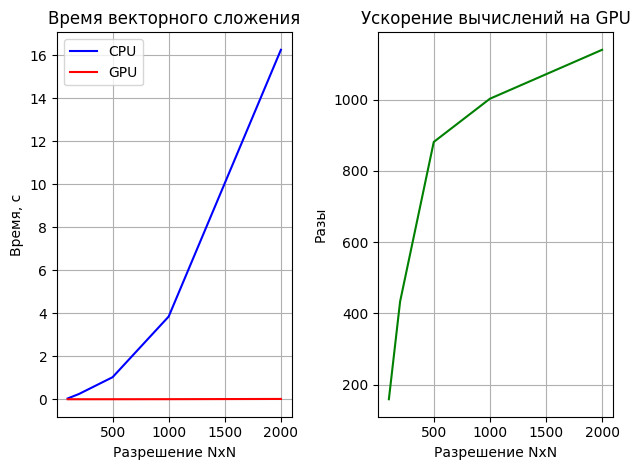

In [38]:
from matplotlib import pyplot as plt
%matplotlib inline

size = [100, 200, 500, 1000, 2000]
gpu_time = [0.00023311, 0.000563385, 0.0011639, 0.00384017, 0.0142648]
cpu_time = [0.0370795, 0.244053, 1.0255, 3.849, 16.2571]

assert len(size) == len(gpu_time)
assert len(size) == len(cpu_time)

acceleration = [cpu / gpu for cpu, gpu in zip(cpu_time, gpu_time)]

fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].plot(size, cpu_time, label='CPU', color='b')
axes[0].plot(size, gpu_time, label='GPU', color='r')
axes[0].grid(True)
axes[0].legend()
axes[0].set_xlabel("Разрешение NxN")
axes[0].set_ylabel("Время, с")
axes[0].set_title("Время векторного сложения")

axes[1].plot(size, acceleration, color='g')
axes[1].grid(True)
axes[1].set_xlabel("Разрешение NxN")
axes[1].set_ylabel("Разы")
axes[1].set_title("Ускорение вычислений на GPU")

plt.tight_layout()
plt.show()